In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import yasa
import seaborn as sns
import ghibtools as gh
import mne
import glob
import time
import datetime
import yasa
from scipy import signal
import json
from params import *

In [3]:
rows = []
for subject in subjects:
    for ev in ['spindles','slowwaves']:
        for encoder in ['yasa','human']:
            events = pd.read_excel(f'../event_detection/{subject}_{ev}_reref_{encoder}.xlsx', index_col = 0)
            for normalize, param  in zip(['proportion', 'N'], [True,False]):
                proportion = events['Stage_Letter'].value_counts(normalize=param)
                for stage in proportion.index:
                    rows.append([subject, ev, encoder, normalize, stage, proportion[stage]])
proportions = pd.DataFrame(rows, columns = ['subject','event','encoder','normalize','stage','count'])

<AxesSubplot: xlabel='stage', ylabel='count'>

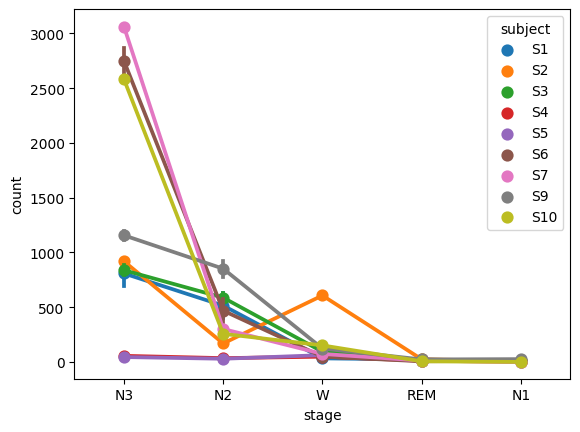

In [5]:
for ev in ['slowwaves','spindles']:
    sns.pointplot(data=proportions[(proportions['normalize'] == 'N') & (proportions['event'] == ev)] , x = 'stage', y = 'count', hue = 'subject', order = ['W','R','N1','N2','N3'])

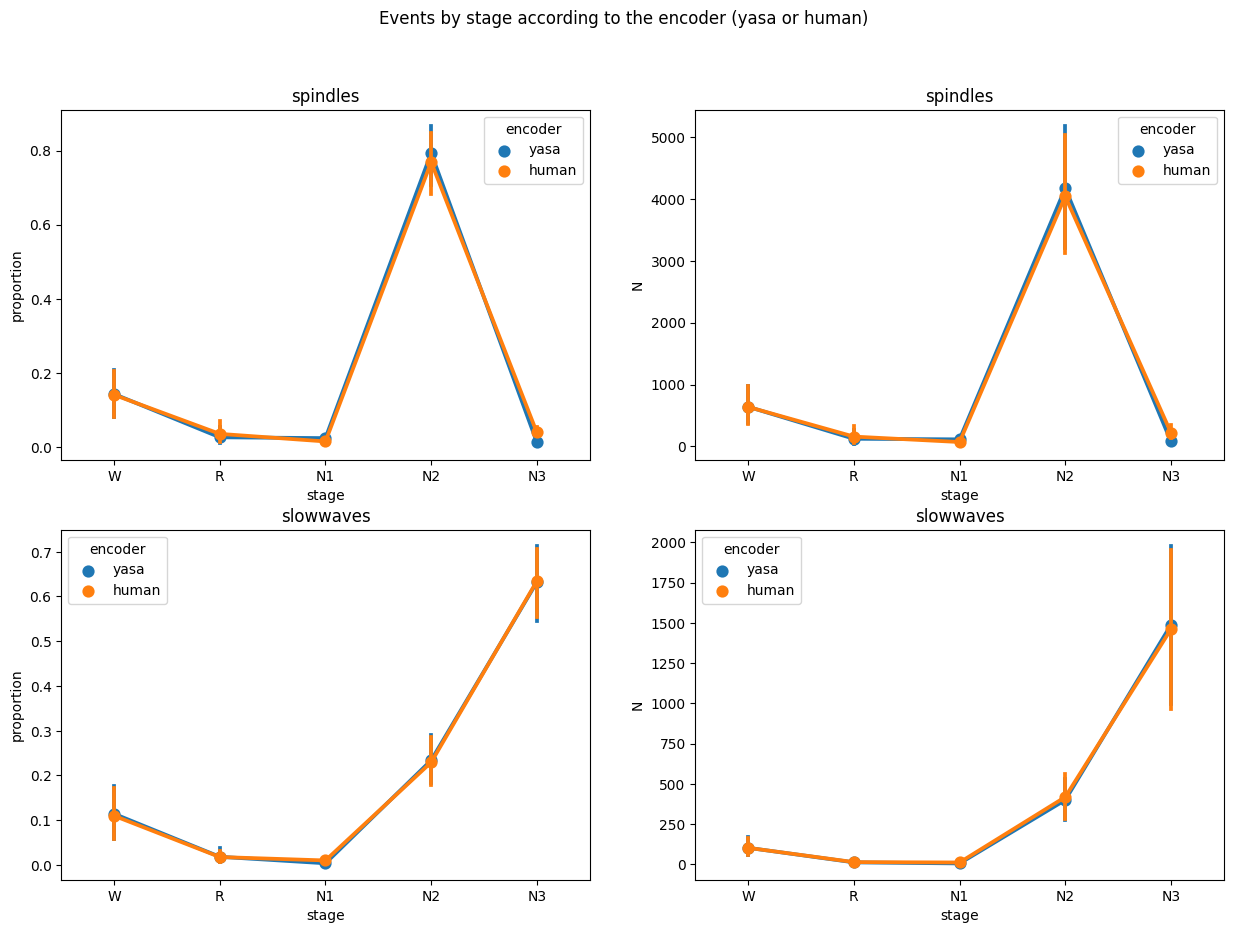

In [14]:
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (15,10))
fig.suptitle('Events by stage according to the encoder (yasa or human)')
for row, ev in enumerate(['spindles','slowwaves']):
    prop_ev = proportions[proportions['event'] == ev]
    for col, normalization in enumerate(prop_ev['normalize'].unique()):
        ax = axs[row, col]
        prop_normalization = prop_ev[prop_ev['normalize'] == normalization]
        sns.pointplot(data=prop_normalization, x = 'stage', y = 'count', ax=ax, hue = 'encoder', order = ['W','R','N1','N2','N3'], bw = 0.2, inner = 'point')
        ax.set_title(ev)
        ax.set_ylabel(normalization)
# plt.savefig('../autres/events_by_stage_by_encoder_bis')

In [20]:
events['Stage_Letter'].value_counts(normalize=True)['N3']

0.49783549783549785

In [7]:
hypno_human = pd.read_csv(f'../hypnos/hypno_upsampled_{subject}_human.csv', index_col = 0)
hypno_yasa = pd.read_csv(f'../hypnos/hypno_upsampled_{subject}_yasa.csv', index_col = 0)

<AxesSubplot: xlabel='Time [hrs]', ylabel='Stage'>

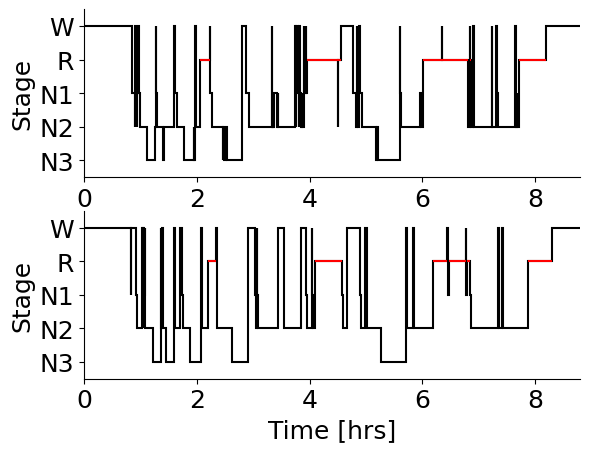

In [16]:
fig, axs = plt.subplots(nrows = 2)
ax = axs[0]
yasa.plot_hypnogram(hypno_yasa['int'], sf_hypno = srate, ax=ax)
ax = axs[1]
yasa.plot_hypnogram(hypno_human['int'], sf_hypno = srate, ax=ax)

In [6]:
events

,Start,NegPeak,MidCrossing,PosPeak,End,Duration,ValNegPeak,ValPosPeak,PTP,Slope,Frequency,SigmaPeak,PhaseAtSigmaPeak,ndPAC,Stage,Channel,IdxChannel,Stage_Letter
0,377.964844,378.238281,378.507812,378.722656,378.929688,0.9648,-146.583986,113.905961,260.489948,966.455458,1.036484,378.136719,2.564395,0.314444,0,Fp2,0,W
1,531.148438,531.523438,531.851562,532.171875,532.593750,1.4453,-118.270723,139.794337,258.065060,786.483993,0.691898,531.183594,1.731909,0.294620,0,Fp2,0,W
2,532.593750,533.136719,533.460938,534.207031,534.421875,1.8281,-140.527298,85.881739,226.409037,698.321849,0.547016,533.734375,-0.602353,0.206148,0,Fp2,0,W
3,554.710938,555.011719,555.312500,555.757812,556.003906,1.2930,-85.189113,80.082351,165.271464,549.473958,0.773395,555.117188,-2.541248,0.462211,0,Fp2,0,W
4,1953.964844,1954.898438,1955.214844,1955.554688,1956.015625,2.0508,-84.591890,106.963281,191.555171,605.408934,0.487615,1955.847656,0.859146,0.378297,0,Fp2,0,W
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1381,19990.582031,19990.980469,19991.296875,19991.570312,19991.863281,1.2812,-116.977969,83.354571,200.332540,633.149756,0.780518,19990.933594,3.028463,0.353783,3,O2,10,N3
1382,20027.140625,20027.402344,20027.636719,20027.878906,20028.250000,1.1094,-75.515415,76.048963,151.564378,646.674678,0.901388,20028.292969,1.633559,0.341444,3,O2,10,N3
1383,20086.566406,20087.023438,20087.292969,20087.531250,20087.796875,1.2305,-91.327002,77.966392,169.293394,628.103026,0.812678,20086.234375,1.550990,0.306676,3,O2,10,N3
1384,25136.699219,25137.011719,25137.273438,25137.507812,25137.769531,1.0703,-94.366229,75.166662,169.532891,647.767463,0.934317,25137.652344,0.752211,0.166758,2,O2,10,N2


In [8]:
hypno_human

,str,int
0,W,0
1,W,0
2,W,0
3,W,0
4,W,0
...,...,...
8104955,W,0
8104956,W,0
8104957,W,0
8104958,W,0


In [15]:
concat = []
for subject in ['S1','S2','S3','S4','S5','S6','S7','S9','S10','S11','S12','S13','S14','S15','S16','S17','S18','S19','S20']:
    for encoder in ['yasa','human']:
        stats = pd.read_excel(f'../subject_characteristics/{subject}_sleep_stats_{encoder}.xlsx', index_col = 0)
        concat.append(stats)
stats_all = pd.concat(concat)

In [16]:
stats_all

,subject,encoder,TIB,SPT,WASO,TST,N1,N2,N3,REM,...,Lat_N2,Lat_N3,Lat_REM,%N1,%N2,%N3,%REM,%NREM,SE,SME
0,S1,yasa,527.666667,440.000000,32.5,407.500000,30.000000,190.500000,64.5,122.500000,...,54.0,66.5,123.5,7.361963,46.748466,15.828221,30.061350,69.938650,77.226785,92.613636
0,S1,human,527.666667,448.000000,54.0,394.000000,13.000000,209.500000,72.5,99.000000,...,56.5,73.0,131.5,3.299492,53.172589,18.401015,25.126904,74.873096,74.668351,87.946429
0,S2,yasa,560.650000,520.150000,45.0,475.150000,29.500000,242.650000,83.0,120.000000,...,44.5,55.5,192.5,6.208566,51.068084,17.468168,25.255183,74.744817,84.749844,91.348649
0,S2,human,560.650000,523.150000,41.0,482.150000,30.000000,228.150000,100.5,123.500000,...,38.0,53.0,191.5,6.222130,47.319299,20.844136,25.614435,74.385565,85.998395,92.162860
0,S3,yasa,598.850000,580.850000,43.5,537.350000,36.000000,290.500000,73.5,137.350000,...,19.5,47.0,187.0,6.699544,54.061599,13.678236,25.560622,74.439378,89.730316,92.510975
0,S3,human,598.850000,582.850000,34.5,548.350000,11.000000,293.000000,112.5,131.850000,...,17.5,46.0,187.0,2.006018,53.433026,20.516094,24.044862,75.955138,91.567170,94.080810
0,S4,yasa,524.583333,503.500000,51.5,452.000000,61.000000,241.000000,50.0,100.000000,...,23.5,37.0,107.0,13.495575,53.318584,11.061947,22.123894,77.876106,86.163622,89.771599
0,S4,human,524.583333,508.000000,54.0,454.000000,27.500000,257.500000,74.5,94.500000,...,14.0,33.5,107.0,6.057269,56.718062,16.409692,20.814978,79.185022,86.544877,89.370079
0,S5,yasa,498.783333,488.283333,50.0,438.283333,53.500000,216.283333,63.5,105.000000,...,40.5,55.5,92.0,12.206716,49.347834,14.488345,23.957105,76.042895,87.870485,89.760044
0,S5,human,498.783333,488.783333,57.5,431.283333,55.500000,207.283333,93.5,75.000000,...,39.0,49.5,92.0,12.868571,48.061986,21.679484,17.389960,82.610040,86.467070,88.236096


In [17]:
cols = ['%N1','%N2','%N3','%REM','%NREM','SE']

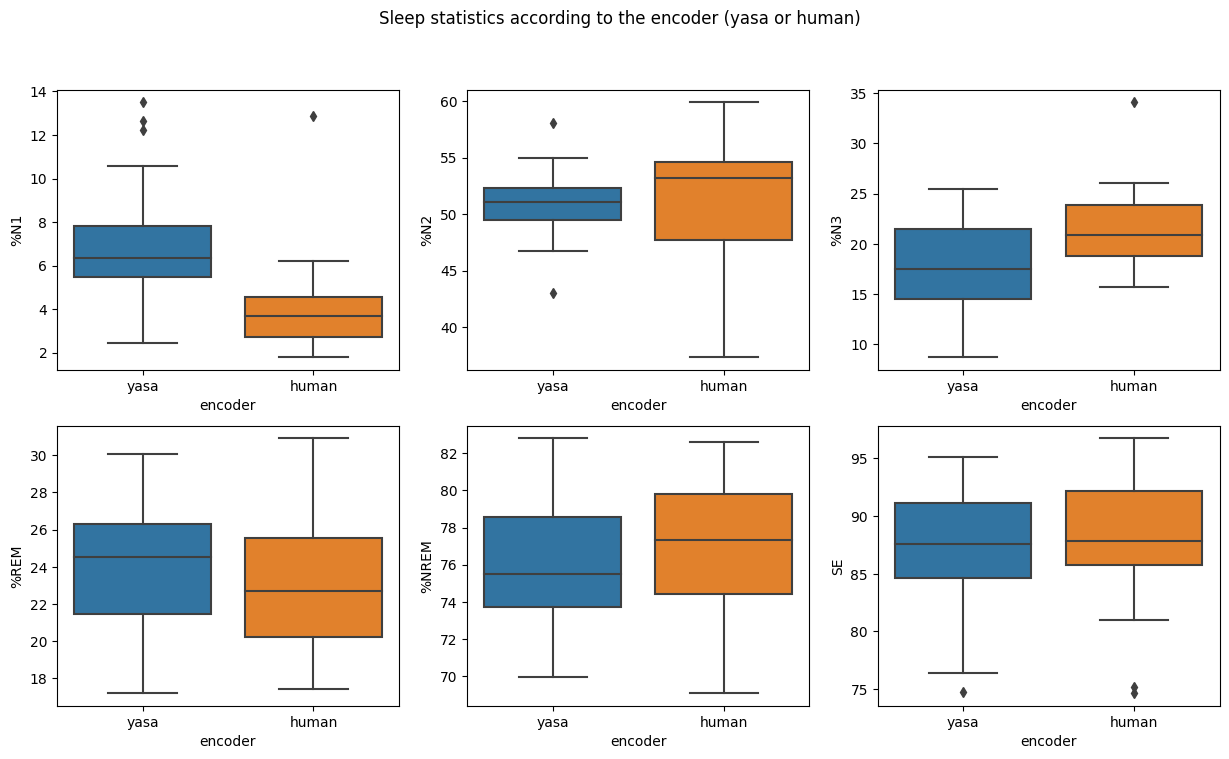

In [24]:
nrows = 2
ncols = 3
cols_plot = np.array(cols).reshape(nrows,ncols)
fig, axs = plt.subplots(nrows, ncols, figsize = (15,8))
fig.suptitle('Sleep statistics according to the encoder (yasa or human)')
for row in range(nrows) : 
    for col in range(ncols):
        ax = axs[row, col]
        # sns.violinplot(data=stats_all, x = 'encoder', y = cols_plot[row,col], ax=ax, inner = 'point', bw = 0.2)
        sns.boxplot(data=stats_all, x = 'encoder', y = cols_plot[row,col], ax=ax)
# plt.savefig('../autres/staging_by_encoder_bis')

/mnt/autofs/cmo/users/ValentinGhibaudo/ghibtools/ghibtools/stats.py:358: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  estimators = pd.concat([df.groupby(predictor).mean()[outcome].reset_index(), df.groupby(predictor).std()[outcome].reset_index()[outcome].rename('sd')], axis = 1).round(2).set_index(predictor)
/mnt/autofs/cmo/users/ValentinGhibaudo/ghibtools/ghibtools/stats.py:358: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  estimators = pd.concat([df.groupby(predictor).mean()[outcome].reset_index(), df.groupby(predictor).std()[outcome].reset_index()[outcome].rename('sd')], axis = 1).round(2).set_index(pred

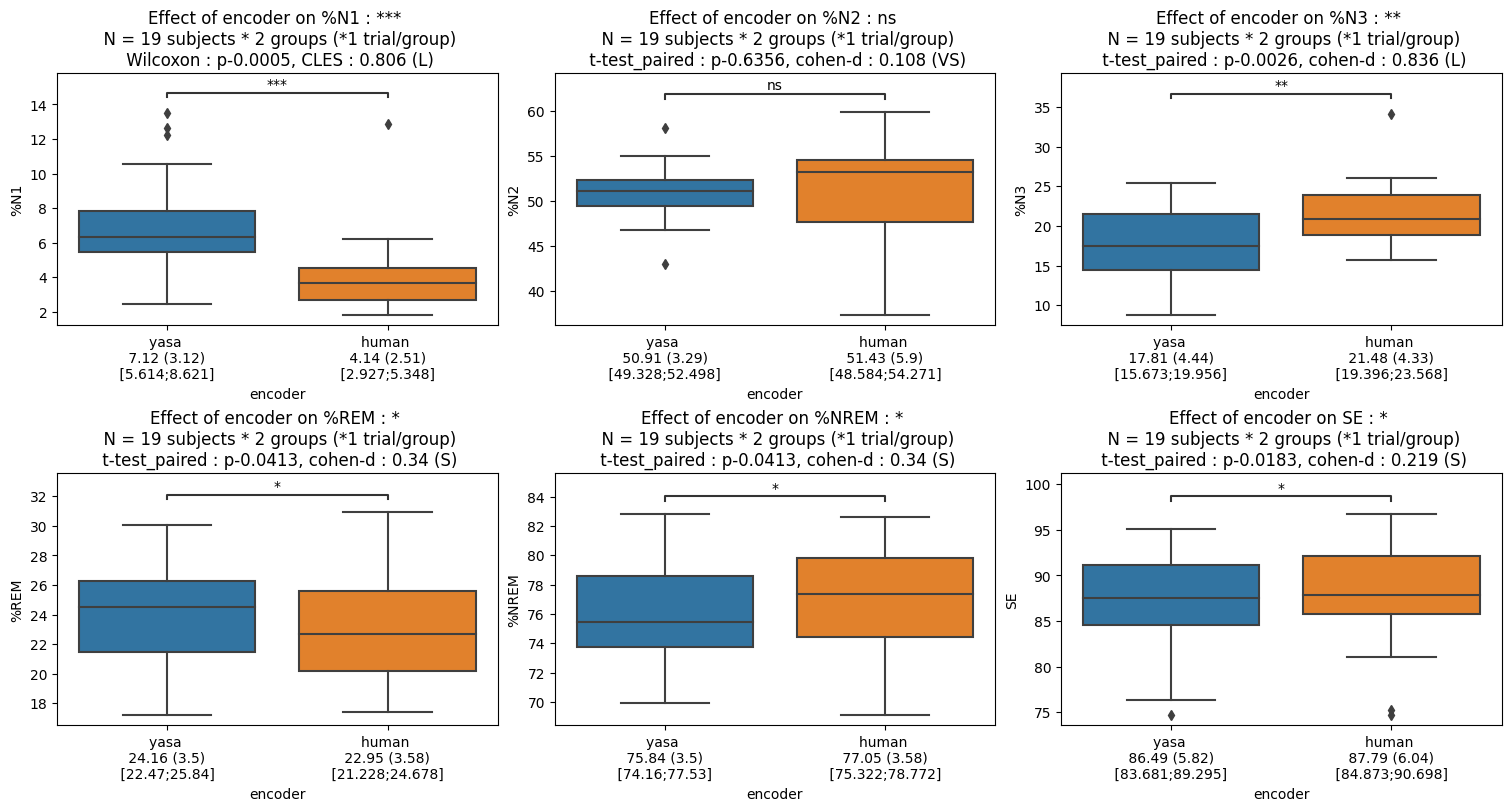

In [216]:
nrows = 2
ncols = 3
cols_plot = np.array(cols).reshape(nrows,ncols)
fig, axs = plt.subplots(nrows, ncols, figsize = (15,8), constrained_layout = True)
for row in range(nrows) : 
    for col in range(ncols):
        ax = axs[row, col]
        # sns.violinplot(data=stats_all, x = 'encoder', y = cols_plot[row,col], ax=ax, inner = 'box', bw = 0.2)
        # sns.boxplot(data=stats_all, x = 'encoder', y = cols_plot[row,col], ax=ax)
        gh.auto_stats(df=stats_all, predictor = 'encoder', outcome = cols_plot[row,col], subject = 'subject', ax=ax)

In [101]:
subject = 'S1'

In [102]:
hypno_human = pd.read_csv(f'../hypnos/hypno_upsampled_{subject}_human.csv', index_col = 0)

In [103]:
hypno_yasa = pd.read_csv(f'../hypnos/hypno_upsampled_{subject}_yasa.csv', index_col = 0)

In [107]:
hypno_human.shape

(8104960, 2)

In [108]:
hypno_yasa.shape

(8104960, 2)

In [104]:
hypno_human['str'].value_counts(normalize = True)

N2    0.397031
W     0.253316
R     0.187618
N3    0.137397
N1    0.024637
Name: str, dtype: float64

In [105]:
hypno_yasa['str'].value_counts(normalize = True)

N2    0.361023
R     0.232154
W     0.227732
N3    0.122236
N1    0.056854
Name: str, dtype: float64

In [94]:
t = np.arange(0, hypno_human.shape[0] / srate, 1 / srate)

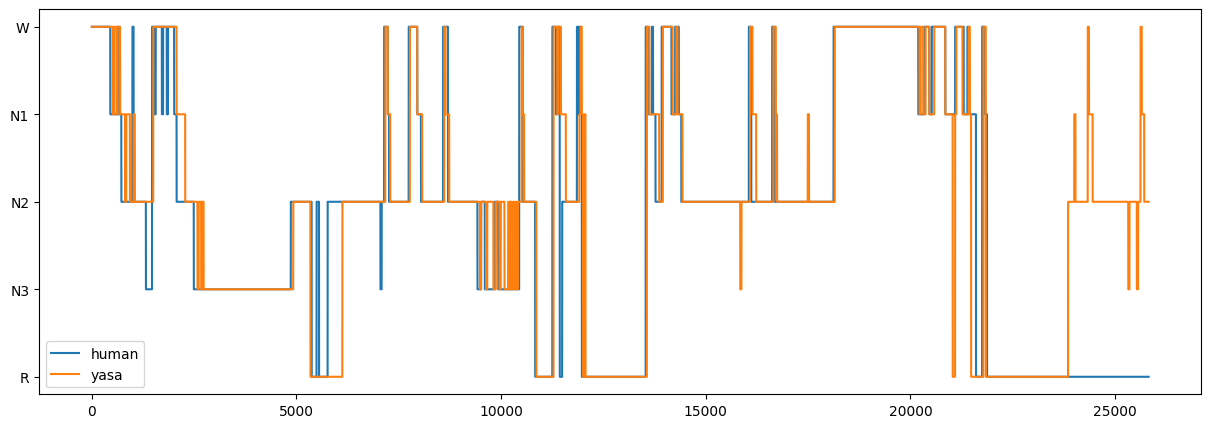

In [95]:
fig, ax = plt.subplots(figsize = (15,5))
ax.plot(t, -hypno_human['int'], label = 'human')
ax.plot(t, -hypno_yasa['int'], label = 'yasa')
ax.set_yticks([0,-1,-2,-3,-4])
ax.set_yticklabels(['W','N1','N2','N3','R'])
ax.legend()
plt.show()

In [40]:
tmin = 40
tmax = 31687

In [125]:
human_hypno = pd.read_csv(f'../data/hypnograms_human_made/Hypno{subject}.txt' , sep = '\t', header = None).rename(columns = {0:'sec',1:'hour',2:'stage',3:'stage_code'})

In [140]:
data = mne.io.read_raw_edf(glob.glob(f'../data/{subject}/*.edf')[0], verbose = False, preload = True)

In [141]:
data.info['ch_names']

['EEG Fp2',
 'EEG A1',
 'EEG Cz',
 'EEG C4',
 'EEG T4',
 'EEG Pz',
 'EEG O2',
 'ECG',
 'Menton',
 'EOGDt',
 'EOGG',
 'JBdt',
 'JBg',
 'EEG A2',
 'EEG Fz',
 'THERM',
 'SAT',
 'THO',
 'ABD',
 'PTT',
 'FC',
 'Pouls',
 'POS',
 'Micro',
 'EEG Fp1',
 'EEG C3',
 'EEG T3',
 'EEG O1',
 'PCO2',
 'DEBIT',
 'CPAP',
 'PRESSION',
 '-']

In [127]:
data.shape

(33, 8135680)

In [128]:
human_hypno

,sec,hour,stage,stage_code
0,30,00:00:30,W,1
1,60,00:01:00,W,1
2,90,00:01:30,W,1
3,120,00:02:00,W,1
4,150,00:02:30,W,1
...,...,...,...,...
1067,31650,08:47:30,W,1
1068,31680,08:48:00,W,1
1069,31710,08:48:30,W,1
1070,31740,08:49:00,W,1


In [129]:
human_hypno['stage'].value_counts()

N2     419
W      284
REM    198
N3     145
N1      26
Name: stage, dtype: int64

In [91]:
mapper = {'W  ':'W','N1 ':'N1','N2 ':'N2','N3 ':'N3','REM':'R'}

In [130]:
human_hypno['stage_relabeled'] = human_hypno['stage'].map(mapper)

In [131]:
human_hypno['stage_relabeled'].value_counts()

N2    419
W     284
R     198
N3    145
N1     26
Name: stage_relabeled, dtype: int64

In [132]:
human_hypno['stage_code'].value_counts()

4    419
1    284
2    198
5    145
3     26
Name: stage_code, dtype: int64

In [45]:
human_hypno[human_hypno['sec'] < tmax]

,sec,hour,stage,stage_code
0,30,00:00:30,W,1
1,60,00:01:00,W,1
2,90,00:01:30,W,1
3,120,00:02:00,W,1
4,150,00:02:30,W,1
...,...,...,...,...
1064,31560,08:46:00,W,1
1065,31590,08:46:30,W,1
1066,31620,08:47:00,W,1
1067,31650,08:47:30,W,1


In [108]:
np.unique(human_hypno['stage'].values)

array(['N1 ', 'N2 ', 'N3 ', 'REM', 'W  '], dtype=object)

In [138]:
human_hypno

,sec,hour,stage,stage_code,stage_relabeled
0,30,00:00:30,W,1,W
1,60,00:01:00,W,1,W
2,90,00:01:30,W,1,W
3,120,00:02:00,W,1,W
4,150,00:02:30,W,1,W
...,...,...,...,...,...
1067,31650,08:47:30,W,1,W
1068,31680,08:48:00,W,1,W
1069,31710,08:48:30,W,1,W
1070,31740,08:49:00,W,1,W


In [139]:
human_hypno['sec'] > None

0       False
1       False
2       False
3       False
4       False
        ...  
1067    False
1068    False
1069    False
1070    False
1071    False
Name: sec, Length: 1072, dtype: bool

In [113]:
human_hypno['stage_relabeled'].value_counts()

N2    419
W     284
R     198
N3    145
N1     26
Name: stage_relabeled, dtype: int64

In [133]:
test = yasa.hypno_upsample_to_data(hypno=human_hypno['stage_relabeled'].values, sf_hypno = 1/30, data = data, sf_data = 256)

12-Dec-22 16:07:46 | WARNING | Hypnogram is LONGER than data by 380.00 seconds. Cropping hypnogram to match data.size.


In [134]:
np.unique(test)

array(['N1', 'N2', 'N3', 'R', 'W'], dtype=object)

In [135]:
human_hypno['stage'].value_counts(normalize = True)

N2     0.390858
W      0.264925
REM    0.184701
N3     0.135261
N1     0.024254
Name: stage, dtype: float64

In [136]:
np.unique(test)

array(['N1', 'N2', 'N3', 'R', 'W'], dtype=object)

In [137]:
pd.Series(test).value_counts(normalize = True)

N2    0.395532
W     0.256136
R     0.186910
N3    0.136879
N1    0.024544
dtype: float64

In [5]:
glob.glob(f'../data/{subject}/*.edf')

['../data/S8/KevDen1.edf', '../data/S8/KevDen2.edf']

In [9]:
input_files = glob.glob(f'../data/{subject}/*.edf')
raws = []
for file in input_files :
    raws.append(mne.io.read_raw_edf(file, verbose = False, preload = True))
raw = mne.concatenate_raws(raws)

In [20]:
raw.times[-1]

28218.99609375

In [24]:
start_meas = raw.info['meas_date']
secs = raw.times[-1]
stop_meas = start_meas + datetime.timedelta(seconds=secs)

In [25]:
start_meas

datetime.datetime(2021, 10, 19, 22, 11, 44, tzinfo=datetime.timezone.utc)

In [26]:
stop_meas

datetime.datetime(2021, 10, 20, 6, 2, 2, 996094, tzinfo=datetime.timezone.utc)

In [18]:
raw.info

<Info | 7 non-empty values
 bads: []
 ch_names: EEG Fp2, EEG A1, EEG Cz, EEG C4, EEG T4, EEG Pz, EEG O2, ECG, ...
 chs: 33 EEG
 custom_ref_applied: False
 highpass: 0.2 Hz
 lowpass: 100.0 Hz
 meas_date: 2021-10-19 22:11:44 UTC
 nchan: 33
 projs: []
 sfreq: 256.0 Hz
>

In [19]:
raw.__dict__

{'_last_samps': array([3686399, 3537663]),
 '_first_samps': array([0, 0]),
 'info': <Info | 7 non-empty values
  bads: []
  ch_names: EEG Fp2, EEG A1, EEG Cz, EEG C4, EEG T4, EEG Pz, EEG O2, ECG, ...
  chs: 33 EEG
  custom_ref_applied: False
  highpass: 0.2 Hz
  lowpass: 100.0 Hz
  meas_date: 2021-10-19 22:11:44 UTC
  nchan: 33
  projs: []
  sfreq: 256.0 Hz
 >,
 'buffer_size_sec': 1.0,
 '_cals': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 '_raw_extras': [{'events': [],
   'units': array([1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06,
          1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06,
          1.e+00, 1.e-06, 1.e-06, 1.e+00, 1.e+00, 1.e+00, 1.e+00, 1.e-06,
          1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e+00, 1.e+00, 1.e+00, 1.e+00,
          1.e+00]),
   'ch_names': ['EEG Fp2',
    'EEG A1',
    'EEG Cz',
    'EEG C4',
    'EEG T4',
    'EEG Pz'

In [17]:
raw.get_data().shape[1] / 256

28219.0

In [40]:
light_times = pd.read_excel('../data/lights_recordings.xlsx', index_col = 0).set_index('subject', drop = True)

In [33]:
crop_duration_at_beginning = (datetime.datetime.strptime(light_times.loc[subject, 'light out'], "%H:%M:%S") - datetime.datetime.strptime(light_times.loc[subject, 'recording start time'], "%H:%M:%S")).seconds
crop_duration_at_end = (datetime.datetime.strptime(light_times.loc[subject, 'recording stop time'], "%H:%M:%S") - datetime.datetime.strptime(light_times.loc[subject, 'light on'], "%H:%M:%S")).seconds


In [35]:
crop_duration_at_beginning

2400

In [34]:
crop_duration_at_end.seconds

AttributeError: 'int' object has no attribute 'seconds'

In [42]:
for subject in subjects : 
    crop_duration_at_beginning = (datetime.datetime.strptime(light_times.loc[subject, 'light out'], "%H:%M:%S") - datetime.datetime.strptime(light_times.loc[subject, 'recording start time'], "%H:%M:%S")).seconds
    if light_times.loc[subject, 'light on before stop recording'] == 'yes':
        crop_duration_at_end = (datetime.datetime.strptime(light_times.loc[subject, 'recording stop time'], "%H:%M:%S") - datetime.datetime.strptime(light_times.loc[subject, 'light on'], "%H:%M:%S")).seconds
    else:
        crop_duration_at_end = 'fin de recording'
    print(subject , crop_duration_at_beginning , crop_duration_at_end)

S1 80 40
S2 361 fin de recording
S3 0 fin de recording
S4 1020 599
S5 3417 fin de recording
S6 198 fin de recording
S7 5445 fin de recording
S8 2400 fin de recording
S9 6279 fin de recording
S10 111 fin de recording
S11 12526 fin de recording
S12 285 fin de recording
S13 910 fin de recording
S14 3780 fin de recording
S15 312 fin de recording
S16 634 fin de recording
S17 5098 1362
S18 0 418
S19 786 fin de recording
S20 61 fin de recording


In [ ]:
print(crop_duration_at_beginning , crop_duration_at_end)

In [18]:
rows = []
for subject in subjects:
    hypno_ia = pd.read_excel(f'../hypnos/hypno_{subject}.xlsx', index_col = 0)['str'].values
    hypno_human = pd.read_csv(f'../autres/light_hypnos/Hypno{subject}.txt', sep = '\t', header = None)[2].values
    if hypno_ia.size == hypno_human.size:
        problem = '-'
    else:
        problem = 'MISMATCH'
    rows.append([subject, hypno_ia.size, hypno_human.size, problem])
hypnos = pd.DataFrame(rows, columns = ['sub','ia n epochs','human n epochs', 'problem ?'])
hypnos.to_excel('../autres/mismatch_hypnogrammes.xlsx')

In [19]:
hypnos

,sub,ia n epochs,human n epochs,problem ?
0,S1,1059,1072,MISMATCH
1,S2,1133,1133,-
2,S3,1197,1197,-
3,S4,1103,1103,-
4,S5,1111,1111,-
5,S6,1025,1025,-
6,S7,1227,1227,-
7,S8,480,940,MISMATCH
8,S9,1293,1294,MISMATCH
9,S10,1073,1073,-


In [5]:
def get_stage_duration(sleep_stats, subject, stage):
    return sleep_stats.set_index('subject').loc[subject, stage]

In [18]:
sleep_stats = pd.read_excel(f'../subject_characteristics/global_sleep_stats.xlsx', index_col = 0)
rows = []
evs = ['spindles','slowwaves']
for ev in evs:
    for sub in subjects:
        ev_masto = pd.read_excel(f'../event_detection/{sub}_{ev}_reref.xlsx', index_col = 0)
        if ev == 'spindles':
            ev_bipol = pd.read_excel(f'../event_detection/{sub}_spindles.xlsx', index_col = 0)
        elif ev == 'slowwaves':
            ev_bipol = pd.read_excel(f'../event_detection/{sub}_slowwaves_bipol.xlsx', index_col = 0)
        modes = {'bipol':ev_bipol, 'masto':ev_masto}
        for mode in modes.keys():
            df = modes[mode]
            n_ev_total = df.shape[0]
            for stage in ['N2','N3']:
                df_stage = df[df['Stage_Letter'] == stage]
                n_ev_stage = df_stage.shape[0]
                stage_duration = get_stage_duration(sleep_stats, sub, stage)
                density_by_stage = n_ev_stage / stage_duration
                for chan in df_stage['Channel'].unique():
                    df_stage_chan = df_stage[df_stage['Channel'] == chan]
                    n_ev_stage_chan = df_stage_chan.shape[0]
                    density_by_stage_by_chan = n_ev_stage_chan / stage_duration

                    row = [ev ,sub, mode, stage, chan, n_ev_total, stage_duration, n_ev_stage, density_by_stage, n_ev_stage_chan, density_by_stage_by_chan ]
                    rows.append(row)
df_spindles_comparison = pd.DataFrame(rows, columns = ['event','subject','mode','stage','chan','n_events_total','stage_duration','n_events_stage','density_by_stage','n_events_stage_chan','density_by_stage_by_chan'])

In [19]:
df_spindles_comparison

,event,subject,mode,stage,chan,n_events_total,stage_duration,n_events_stage,density_by_stage,n_events_stage_chan,density_by_stage_by_chan
0,spindles,S1,bipol,N2,Fp2-C4,4988,199.0,2617,13.150754,547,2.748744
1,spindles,S1,bipol,N2,Fz-Cz,4988,199.0,2617,13.150754,535,2.688442
2,spindles,S1,bipol,N2,Fp1-C3,4988,199.0,2617,13.150754,578,2.904523
3,spindles,S1,bipol,N2,C4-T4,4988,199.0,2617,13.150754,449,2.256281
4,spindles,S1,bipol,N2,C3-T3,4988,199.0,2617,13.150754,441,2.216080
...,...,...,...,...,...,...,...,...,...,...,...
1225,slowwaves,S20,masto,N3,T4,4064,88.0,3458,39.295455,37,0.420455
1226,slowwaves,S20,masto,N3,T3,4064,88.0,3458,39.295455,49,0.556818
1227,slowwaves,S20,masto,N3,Pz,4064,88.0,3458,39.295455,345,3.920455
1228,slowwaves,S20,masto,N3,O1,4064,88.0,3458,39.295455,21,0.238636


In [29]:
df_spindles_comparison[df_spindles_comparison['event'] == 'slowwaves'].groupby(['mode']).mean().loc['bipol','n_events_total']

/tmp/ipykernel_88103/2086013151.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_spindles_comparison[df_spindles_comparison['event'] == 'slowwaves'].groupby(['mode']).mean().loc['bipol','n_events_total']


959.2038461538461

In [41]:
mode_order = {'bipol':['Fp2-C4','Fz-Cz','Fp1-C3','C4-T4','C3-T3','Cz-Pz','T4-O2','T3-O1'], 'masto':['Fp2','Fp1','C3','C4','Fz','Cz','Pz','T4','T3','O1','O2']}

/tmp/ipykernel_88103/1952762728.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  N_mean = df_ev.groupby('mode').mean().loc[mode,'n_events_total']
/tmp/ipykernel_88103/1952762728.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  N_mean = df_ev.groupby('mode').mean().loc[mode,'n_events_total']
/tmp/ipykernel_88103/1952762728.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  N_mean = df_ev.groupby('mode').mean().l

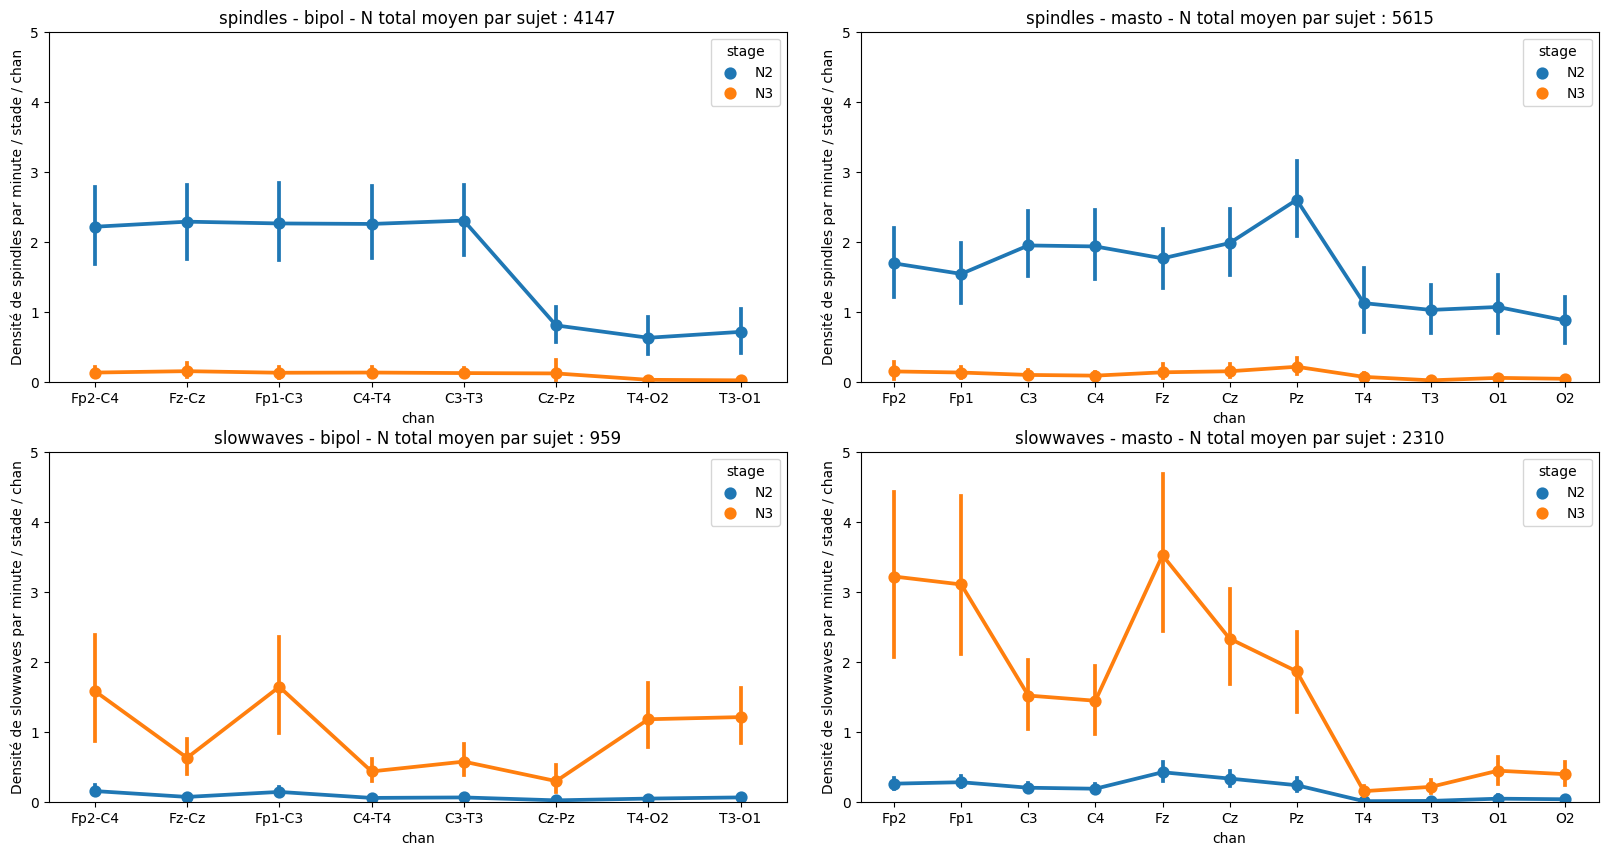

In [42]:
fig, axs = plt.subplots(nrows =2 , ncols = 2, figsize = (20,10))
fig.subplots_adjust(wspace = 0.1)
for r, ev in enumerate(evs):
    df_ev = df_spindles_comparison[df_spindles_comparison['event'] == ev]
    for c, mode in enumerate(['bipol','masto']): 
        ax = axs[r, c]
        N_mean = df_ev.groupby('mode').mean().loc[mode,'n_events_total']
        df_plot = df_ev[df_ev['mode'] == mode]
        sns.pointplot(data = df_plot , x = 'chan', y= 'density_by_stage_by_chan', hue = 'stage', ax=ax, order = mode_order[mode])
        ax.set_title(f'{ev} - {mode} - N total moyen par sujet : {int(N_mean)}')
        ax.set_ylim(0,5)
        ax.set_ylabel(f"Densité de {ev} par minute / stade / chan")

plt.savefig('../autres/ref_mode_events')

In [12]:
subject = 'S1'

In [13]:
data = xr.open_dataarray(f'../preproc/{subject}_reref.nc') # load preprocessed data (lazy load)

In [4]:
def complex_mw(time, n_cycles , freq, a= 1, m = 0): 
    """
    time : time vector of the wavelet
    n_cycles : number of cycles in the wavelet
    freq : frequency of the wavelet
    a : amplitude of the wavelet
    m : x center of the wavelet
    """
    s = n_cycles / (2 * np.pi * freq)
    GaussWin = a * np.exp( -(time - m)** 2 / (2 * s**2)) # real gaussian window
    complex_sinewave = np.exp(1j * 2 *np.pi * freq * time) # complex sinusoidal signal
    cmw = GaussWin * complex_sinewave
    return cmw

In [5]:
tmw = np.arange(-2,2,1/srate)
mw = complex_mw(tmw, n_cycles = 10, freq= 15)

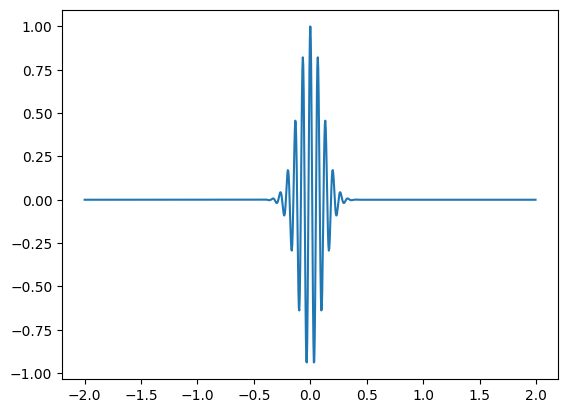

In [6]:
fig, ax = plt.subplots()
ax.plot(tmw, np.real(mw))

In [13]:
def morlet_family(srate, f_start, f_stop, n_step, n_cycles, show = False):
    tmw = np.arange(-5,5,1/srate)
    freqs = np.linspace(f_start,f_stop,n_step) 
    mw_family = np.zeros((freqs.size, tmw.size), dtype = 'complex')
    for i, fi in enumerate(freqs):
        mw_family[i,:] = complex_mw(tmw, n_cycles = n_cycles, freq = fi)
    if show:
        fig, ax = plt.subplots()
        im = ax.pcolormesh(tmw, freqs, np.real(mw_family))
        ax.set_ylabel('Freq [Hz]')
        ax.set_xlabel('Time')
        fig.colorbar(im)
        plt.show()
    return freqs, mw_family

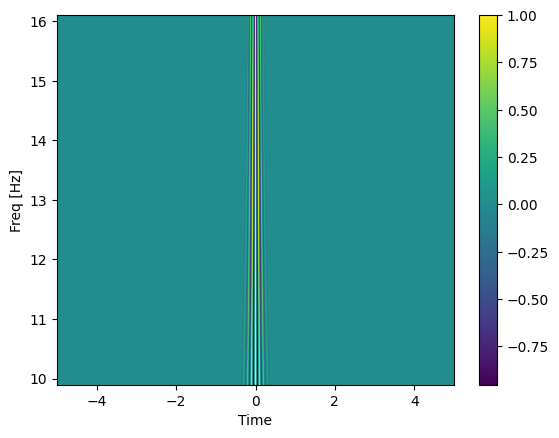

In [149]:
freq , family = morlet_family(srate, f_start = 10, f_stop = 16, n_step = 30, n_cycles = 10, show = True)

In [197]:
t_target = 6000
delta = 500
t_start = t_target - delta
t_stop = t_target + delta
sig = data.sel(chan = 'Fp2', time = slice(t_start,t_stop)).data

In [198]:
family.shape

(30, 2560)

In [199]:
sig

array([58.50873923, 59.92084221, 60.49079536, ..., 71.96393733,
       73.31408636, 74.32315447])

In [200]:
sigs = np.tile(sig, (30,1))

In [201]:
sigs.shape

(30, 256001)

In [202]:
family.shape

(30, 2560)

In [203]:
conv = signal.fftconvolve(sigs, family, mode='same', axes = 1)

In [204]:
conv.shape

(30, 256001)

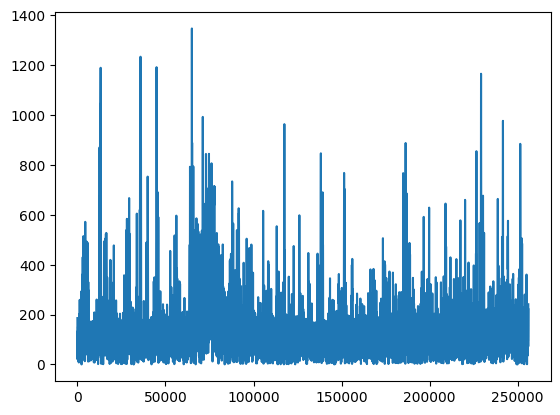

In [205]:
plt.plot(np.abs(conv[0]))

In [8]:
def compute_tf(sig, srate, f_start, f_stop, n_step, n_cycles):
    freqs, family = morlet_family(srate, f_start = f_start, f_stop = f_stop, n_step = n_step, n_cycles = n_cycles)
    tf = np.zeros((family.shape[0], sig.size), dtype = 'complex')
    for i in range(family.shape[0]):
        mw = family[i,:]
        tf[i,:] = signal.fftconvolve(sig, mw, mode = 'same')
    return freqs , np.abs(tf)

In [9]:
def compute_tf_fast(sig, srate, f_start, f_stop, n_step, n_cycles):
    freqs, family = morlet_family(srate, f_start = f_start, f_stop = f_stop, n_step = n_step, n_cycles = n_cycles)
    tf = np.zeros((family.shape[0], sig.size), dtype = 'complex')
    sigs = np.tile(sig, (n_step,1))
    tf = signal.fftconvolve(sigs, family, mode = 'same', axes = 1)
    return freqs , np.abs(tf)

In [10]:
sig = data.sel(chan = 'Fp2').data

In [11]:
sig

array([ 47.87937743,  31.87340769,  40.72806   , ..., -12.05463131,
       -10.82830413,  -5.19066148])

In [14]:
f_start = 10
f_stop = 16
n_step = 50
n_cycles = 30
t1 = time.perf_counter()
f, tf_slow = compute_tf(sig, srate, f_start, f_stop, n_step, n_cycles)
t2 = time.perf_counter()
print('slow' , t2-t1)
del tf_slow

t1 = time.perf_counter()
f, tf_fast = compute_tf_fast(sig, srate, f_start, f_stop, n_step, n_cycles)
t2 = time.perf_counter()
print('fast' , t2-t1)

slow 80.07882622885518
fast 69.65243681194261


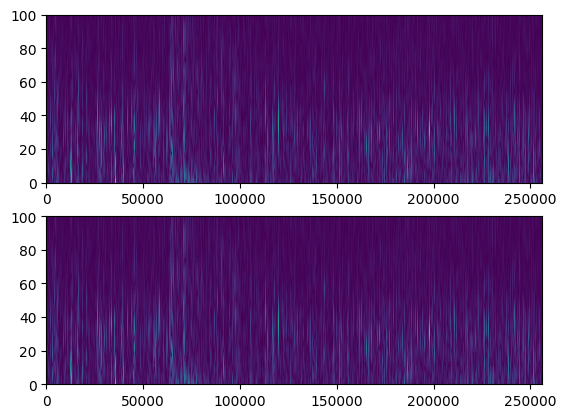

In [209]:
fig, axs = plt.subplots(nrows = 2)
ax = axs[0]
ax.pcolormesh(tf_slow)
ax = axs[1]
ax.pcolormesh(tf_fast)


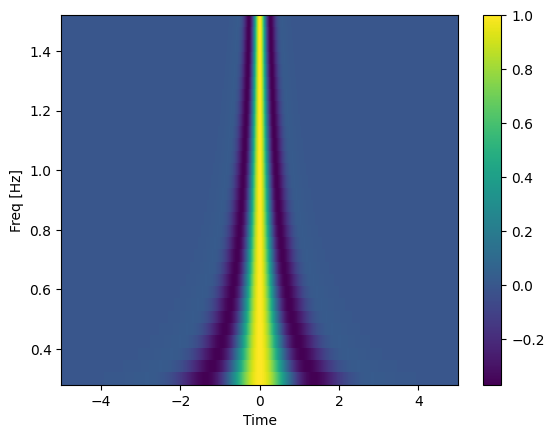

0.020325036020949483


In [12]:
f_start = 0.3
f_stop = 1.5
n_step = 30
n_cycles = 2
freq, family = morlet_family(srate, f_start = f_start, f_stop = f_stop, n_step = n_step, n_cycles = n_cycles, show = True)
f_slow = np.linspace(f_start,f_stop,n_step) 
t = np.arange(0, sig.size/srate, 1 / srate)

t1 = time.perf_counter()
tf_slow = np.zeros((family.shape[0], sig.size), dtype = 'complex')
for i in range(family.shape[0]):
    mw = family[i,:]
    tf_slow[i,:] = signal.fftconvolve(sig, mw, mode = 'same')
t2 = time.perf_counter()
print(t2-t1)

In [13]:
for i in range(family.shape[0]):
    mw = family[i,:]
    tf_slow[i,:] = signal.fftconvolve(sig, mw, mode = 'same')

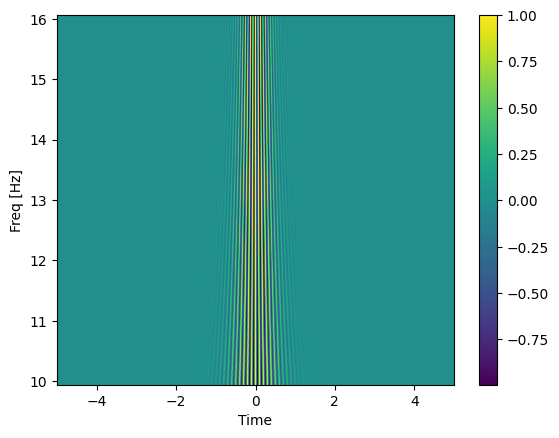

In [16]:
f_start = 10
f_stop = 16
n_step = 50
n_cycles = 30
freq, family = morlet_family(srate, f_start = f_start, f_stop = f_stop, n_step = n_step, n_cycles = n_cycles, show = True)
f_fast = np.linspace(f_start,f_stop,n_step) 
t = np.arange(0, sig.size/srate, 1 / srate)

tf_fast = np.zeros((family.shape[0], sig.size), dtype = 'complex')
for i in range(family.shape[0]):
    mw = family[i,:]
    tf_fast[i,:] = signal.fftconvolve(sig, mw, mode = 'same', axes = 0)

0.02116361982189119
srate down 51.2
0.005974391009658575
ratio duration 3.5423894732830097


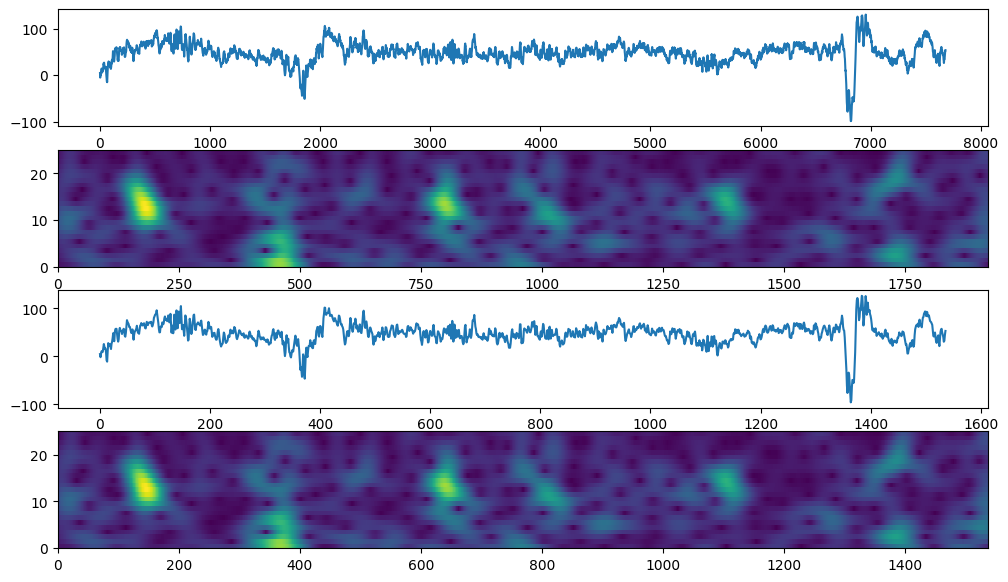

In [50]:
fig, axs = plt.subplots(nrows = 4, figsize = (12,7))
ax = axs[0]
ax.plot(sig)
ax = axs[1]
t1 = time.perf_counter()
f, tf = compute_tf(sig, srate, f_start=10 , f_stop = 16 , n_step = 25, n_cycles = 30)
t2 = time.perf_counter()
duration_full = t2 - t1
print(duration_full)
ax.pcolormesh(signal.decimate(tf, q=4))

factor = 5
srate_down = srate / factor
sig_decimate = signal.decimate(sig, q=factor)
ax = axs[2]
ax.plot(sig_decimate)
ax = axs[3]
t1 = time.perf_counter()
f, tf = compute_tf(sig_decimate, srate_down, f_start=10 , f_stop = 16 , n_step = 25, n_cycles = 30)
print('srate down', srate_down)
t2 = time.perf_counter()
duration_down = t2 - t1
print(duration_down)
ratio_duration = duration_full / duration_down
print('ratio duration', ratio_duration)
ax.pcolormesh(tf)


In [30]:
tf.shape

(25, 1537)

In [576]:
signal.decimate(tf, q=3).shape

(25, 854)

In [19]:
rsp = pd.read_excel('../resp_features/S14_resp_features_tagged.xlsx', index_col = 0).reset_index(drop=True)

In [28]:
rsp.iloc[47:50,:]

,start,transition,stop,start_time,transition_time,stop_time,cycle_duration,inspi_duration,expi_duration,cycle_freq,cycle_ratio,inspi_amplitude,expi_amplitude,inspi_volume,expi_volume,sleep_stage,Spindle_Tag,SlowWave_Tag
47,46876,47172,47618,183.109375,184.265625,186.007812,2.898438,1.156250,1.742188,0.345013,0.398922,2.336883,0.414558,428.069120,151.314314,W,0,0
48,47618,47902,48079,186.007812,187.117188,187.808594,1.800781,1.109375,0.691406,0.555315,0.616052,2.632432,0.503707,500.023048,46.403056,W,0,0
49,48171,48407,48688,188.167969,189.089844,190.187500,2.019531,0.921875,1.097656,0.495164,0.456480,5.709834,0.401803,824.681693,70.175550,W,0,0


In [48]:
rsp_nan = rsp.copy()

In [44]:
inds = []
for c, row in rsp.iterrows():
    if not c == rsp.index[-1]:
        if row['stop'] != rsp.loc[c+1,'start']:
            inds.append(c)
            rsp_nan.loc[c+0.5,:] = np.nan

In [47]:
def add_nan_where_bug_cycle(rsp):
    inds = []
    for c, row in rsp.iterrows():
        if not c == rsp.index[-1]:
            if row['stop'] != rsp.loc[c+1,'start']:
                inds.append(c)
                rsp_nan.loc[c+0.5,:] = np.nan
    return rsp_nan.sort_index()

In [51]:
rsp_nan = add_nan_where_bug_cycle(rsp)

In [52]:
rsp_nan

,start,transition,stop,start_time,transition_time,stop_time,cycle_duration,inspi_duration,expi_duration,cycle_freq,cycle_ratio,inspi_amplitude,expi_amplitude,inspi_volume,expi_volume,sleep_stage,Spindle_Tag,SlowWave_Tag
0.0,826.0,1113.0,1829.0,3.226562,4.347656,7.144531,3.917969,1.121094,2.796875,0.255234,0.286142,0.211454,0.355221,36.386468,195.899702,W,1.0,0.0
1.0,1829.0,1991.0,3050.0,7.144531,7.777344,11.914062,4.769531,0.632812,4.136719,0.209664,0.132678,0.177994,0.344932,17.753210,292.452204,W,0.0,0.0
2.0,3050.0,3158.0,3583.0,11.914062,12.335938,13.996094,2.082031,0.421875,1.660156,0.480300,0.202627,0.108739,0.342820,7.873463,106.109538,W,1.0,0.0
3.0,3583.0,3870.0,4460.0,13.996094,15.117188,17.421875,3.425781,1.121094,2.304688,0.291904,0.327252,0.345997,0.367737,40.528939,181.111471,W,1.0,0.0
4.0,4460.0,4781.0,5341.0,17.421875,18.675781,20.863281,3.441406,1.253906,2.187500,0.290579,0.364359,0.901765,0.375328,135.998563,172.992790,W,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6437.0,6784064.0,6784174.0,6785161.0,26500.250000,26500.679688,26504.535156,4.285156,0.429688,3.855469,0.233364,0.100273,0.130449,0.528058,8.172251,436.921846,W,0.0,0.0
6438.0,6785161.0,6785378.0,6786406.0,26504.535156,26505.382812,26509.398438,4.863281,0.847656,4.015625,0.205622,0.174297,0.277803,0.572156,45.378255,397.242787,W,0.0,0.0
6438.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6439.0,7679043.0,7679270.0,7680175.0,29996.261719,29997.148438,30000.683594,4.421875,0.886719,3.535156,0.226148,0.200530,0.699917,0.499045,114.143331,379.145070,W,0.0,0.0


In [53]:
tf_sel = xr.open_dataarray('../sigma/S1_morlet_sigma.nc')

In [81]:
tf_selected = tf_sel[0,:,:10000]

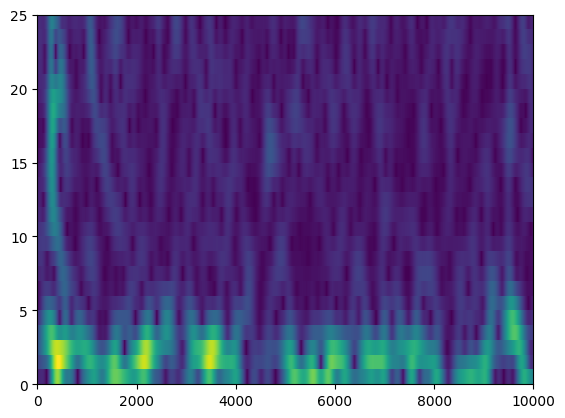

In [82]:
fig, ax = plt.subplots()
ax.pcolormesh(tf_selected.values)

In [83]:
before_reshape = tf_selected.values.T

In [84]:
before_reshape.shape

(10000, 25)

In [85]:
after_reshape = before_reshape.reshape(2,5000,25)

In [86]:
after_reshape[0,:,:].shape

(5000, 25)

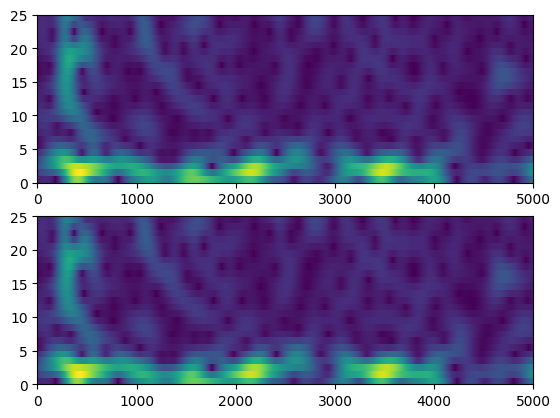

In [87]:
fig, axs = plt.subplots(nrows=2)
ax = axs[0]
ax.pcolormesh(before_reshape[:5000,:].T)
ax = axs[1]
ax.pcolormesh(after_reshape[0,:,:].T)

In [89]:
after_reshape[0,:,:].shape

(5000, 25)

In [96]:
after_reshape[:,:,:].shape

(2, 5000, 25)

In [4]:
concat = []
for subject in subjects:
    concat.append(pd.read_excel(f'../resp_features/{subject}_resp_features.xlsx', index_col = 0))
resp_features_all = pd.concat(concat)

In [5]:
resp_features_all.describe()

,start,transition,stop,start_time,transition_time,stop_time,cycle_duration,inspi_duration,expi_duration,cycle_freq,cycle_ratio,inspi_amplitude,expi_amplitude,inspi_volume,expi_volume
count,1.487920e+05,1.487920e+05,1.487920e+05,148792.000000,148792.000000,148792.000000,148792.000000,148792.000000,148792.000000,148792.000000,148792.000000,148792.000000,148792.000000,148792.000000,148792.000000
mean,3.830030e+06,3.830371e+06,3.830991e+06,14961.056241,14962.387863,14964.808257,3.752016,1.331622,2.420394,0.280809,0.360599,1.407997,1.482114,307.761404,366.124815
std,2.312454e+06,2.312454e+06,2.312477e+06,9033.023099,9033.024461,9033.112709,0.888940,0.302128,0.761855,0.069758,0.068842,1.241238,0.886483,261.518965,211.777353
min,2.300000e+01,2.980000e+02,6.170000e+02,0.089844,1.164062,2.410156,1.003906,0.003906,0.078125,0.066719,0.000707,0.000011,0.100189,0.000000,1.638317
25%,1.820186e+06,1.820519e+06,1.821157e+06,7110.100586,7111.402344,7113.894531,3.234375,1.160156,1.988281,0.238583,0.329086,0.763271,0.843880,172.741542,246.904458
50%,3.730468e+06,3.730830e+06,3.731442e+06,14572.140625,14573.554688,14575.943359,3.726562,1.337891,2.359375,0.268344,0.361864,1.203515,1.326307,266.305421,335.365482
75%,5.788085e+06,5.788376e+06,5.788960e+06,22609.706055,22610.844727,22613.123047,4.191406,1.519531,2.738281,0.309179,0.398109,1.737133,1.923022,380.219316,442.151072
max,8.847463e+06,8.847877e+06,8.848654e+06,34560.402344,34562.019531,34565.054688,14.988281,8.175781,14.921875,0.996109,0.945652,51.515572,21.980689,11423.352578,7883.366798


In [3]:
subject = 'S1'

In [6]:
sp = pd.read_excel(f'../event_detection/{subject}_spindles_reref_yasa.xlsx', index_col = 0)
sw = pd.read_excel(f'../event_detection/{subject}_slowwaves_reref_yasa.xlsx', index_col = 0)
resp = pd.read_excel(f'../resp_features/{subject}_resp_features_tagged_stretch.xlsx', index_col = 0)

In [7]:
resp

,start,transition,stop,start_time,transition_time,stop_time,cycle_duration,inspi_duration,expi_duration,cycle_freq,cycle_ratio,inspi_amplitude,expi_amplitude,inspi_volume,expi_volume,sleep_stage,Spindle_Tag,SlowWave_Tag
0,830072.0,830366.0,830742.0,3242.468750,3243.617188,3245.085938,2.617188,1.148438,1.468750,0.382090,0.438806,0.597351,1.022415,140.457862,199.817849,N2,0.0,0.0
1,830742.0,831050.0,831453.0,3245.085938,3246.289062,3247.863281,2.777344,1.203125,1.574219,0.360056,0.433193,0.783453,1.185641,185.624638,242.396198,N2,0.0,0.0
2,831453.0,831758.0,832254.0,3247.863281,3249.054688,3250.992188,3.128906,1.191406,1.937500,0.319600,0.380774,0.855290,1.050040,189.374591,255.793687,N2,0.0,0.0
3,832254.0,832532.0,832933.0,3250.992188,3252.078125,3253.644531,2.652344,1.085938,1.566406,0.377025,0.409426,1.012843,1.188539,201.438292,242.526160,N2,0.0,0.0
4,832933.0,833206.0,833665.0,3253.644531,3254.710938,3256.503906,2.859375,1.066406,1.792969,0.349727,0.372951,1.114085,1.381477,236.920989,281.482561,N2,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5342,7107535.0,7107803.0,7108271.0,27763.808594,27764.855469,27766.683594,2.875000,1.046875,1.828125,0.347826,0.364130,0.641723,0.806901,132.206773,133.316014,N2,0.0,0.0
5343,7108271.0,7108526.0,7109108.0,27766.683594,27767.679688,27769.953125,3.269531,0.996094,2.273438,0.305854,0.304659,0.565121,0.593981,94.686366,117.922401,N2,0.0,0.0
5344,7109108.0,7109384.0,7109979.0,27769.953125,27771.031250,27773.355469,3.402344,1.078125,2.324219,0.293915,0.316877,0.487084,0.598740,92.500896,116.366330,N2,1.0,0.0
5345,7109979.0,7110236.0,7110695.0,27773.355469,27774.359375,27776.152344,2.796875,1.003906,1.792969,0.357542,0.358939,0.426007,0.466734,75.153252,91.000054,N2,0.0,0.0


In [8]:
sp

,Start,Peak,End,Duration,Amplitude,RMS,AbsPower,RelPower,Frequency,Oscillations,Symmetry,Stage,Channel,IdxChannel,Stage_Letter
0,228.898438,229.207031,229.500000,0.601562,43.163250,11.065300,2.093764,0.352355,11.133398,7,0.509677,0,Fp2,0,W
1,715.457031,715.781250,716.152344,0.695312,36.216540,9.026339,1.969113,0.365975,11.297133,7,0.463687,0,Fp2,0,W
2,904.058594,904.343750,904.617188,0.558594,40.579834,10.443462,2.056274,0.342010,11.665057,7,0.506944,0,Fp2,0,W
3,1471.675781,1471.878906,1472.289062,0.613281,39.161861,10.722740,2.176803,0.352654,11.387810,7,0.329114,0,Fp2,0,W
4,1965.613281,1965.828125,1966.160156,0.546875,38.038044,10.219594,2.062305,0.416243,11.176877,6,0.390071,0,Fp2,0,W
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6062,31569.617188,31569.777344,31570.144531,0.527344,82.200888,19.593828,2.523243,0.323852,11.143110,6,0.301471,0,O2,10,W
6063,31600.726562,31600.804688,31601.386719,0.660156,77.278813,16.591718,2.535366,0.369252,10.909952,7,0.117647,0,O2,10,W
6064,31611.097656,31611.394531,31612.183594,1.085938,78.222356,17.949726,2.650075,0.360097,10.864079,11,0.272401,0,O2,10,W
6065,31616.644531,31616.835938,31617.449219,0.804688,94.877258,22.537750,2.887119,0.370687,10.843349,8,0.236715,0,O2,10,W


In [182]:
subject = 'S13'

In [14]:
sigma_coupling = xr.open_dataarray(f'../sigma_coupling/{subject}_phase_freq_sigma.nc')

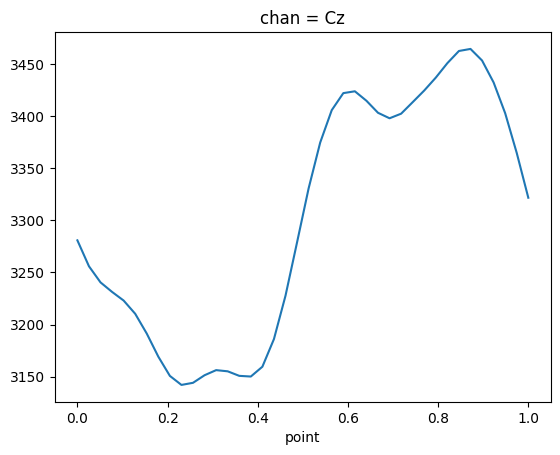

In [16]:
sigma_coupling.mean(['cycle','freq']).sel(chan = 'Cz').plot()

In [19]:
distrib_angles = sigma_coupling.mean(['cycle','freq']).sel(chan = 'Cz').values

In [21]:
import pingouin as pg

In [22]:
distrib_angles

array([3280.84619154, 3255.94044821, 3240.46048474, 3231.3021979 ,
       3223.00497138, 3210.30841856, 3191.28787134, 3169.11450915,
       3150.62884582, 3141.9708046 , 3144.00289349, 3151.28177749,
       3156.17696662, 3155.03908267, 3150.68295402, 3150.03008984,
       3159.45338173, 3186.00934126, 3227.67047651, 3278.96771854,
       3330.78294098, 3374.76162451, 3405.90184231, 3422.2522903 ,
       3424.01021583, 3414.91087509, 3403.36749744, 3398.08988936,
       3402.50220136, 3413.57873862, 3424.77174436, 3437.16432294,
       3451.04746955, 3462.72800927, 3464.70916407, 3453.58949071,
       3432.49843737, 3402.94212552, 3364.77500171, 3321.77534476])

array([0.        , 0.16110732, 0.32221463, 0.48332195, 0.64442926,
       0.80553658, 0.96664389, 1.12775121, 1.28885852, 1.44996584,
       1.61107316, 1.77218047, 1.93328779, 2.0943951 , 2.25550242,
       2.41660973, 2.57771705, 2.73882436, 2.89993168, 3.061039  ,
       3.22214631, 3.38325363, 3.54436094, 3.70546826, 3.86657557,
       4.02768289, 4.1887902 , 4.34989752, 4.51100484, 4.67211215,
       4.83321947, 4.99432678, 5.1554341 , 5.31654141, 5.47764873,
       5.63875604, 5.79986336, 5.96097068, 6.12207799, 6.28318531])

In [34]:
angles = sigma_coupling.coords['point'].values * 2*np.pi

In [35]:
weights = distrib_angles

In [33]:
def get_circ_features(angles, weights): # angles in radians

    z, pval = pg.circ_rayleigh(angles, weights)
    mu = pg.circ_mean(angles, weights) #+ np.pi
    mu = int(np.degrees(mu))
    r = round(pg.circ_r(angles, weights), 3)
    if mu < 0:
        mu = 360 + mu

    return pval, mu, r

In [37]:
p, mu, r = get_circ_features(angles, weights)

In [27]:
r = pg.circ_mean(sigma_coupling.coords['point'].values * 2*np.pi , w = distrib_angles)

In [31]:
pg.circ_rayleigh(sigma_coupling.coords['point'].values * 2*np.pi , w = distrib_angles)

(175.83023132820094, 4.0997312831725034e-77)

In [29]:
sigma_coupling.mean()

<xarray.DataArray ()>
array(2105.88446546)

In [185]:
sigma_coupling.std()

<xarray.DataArray ()>
array(35.14908082)

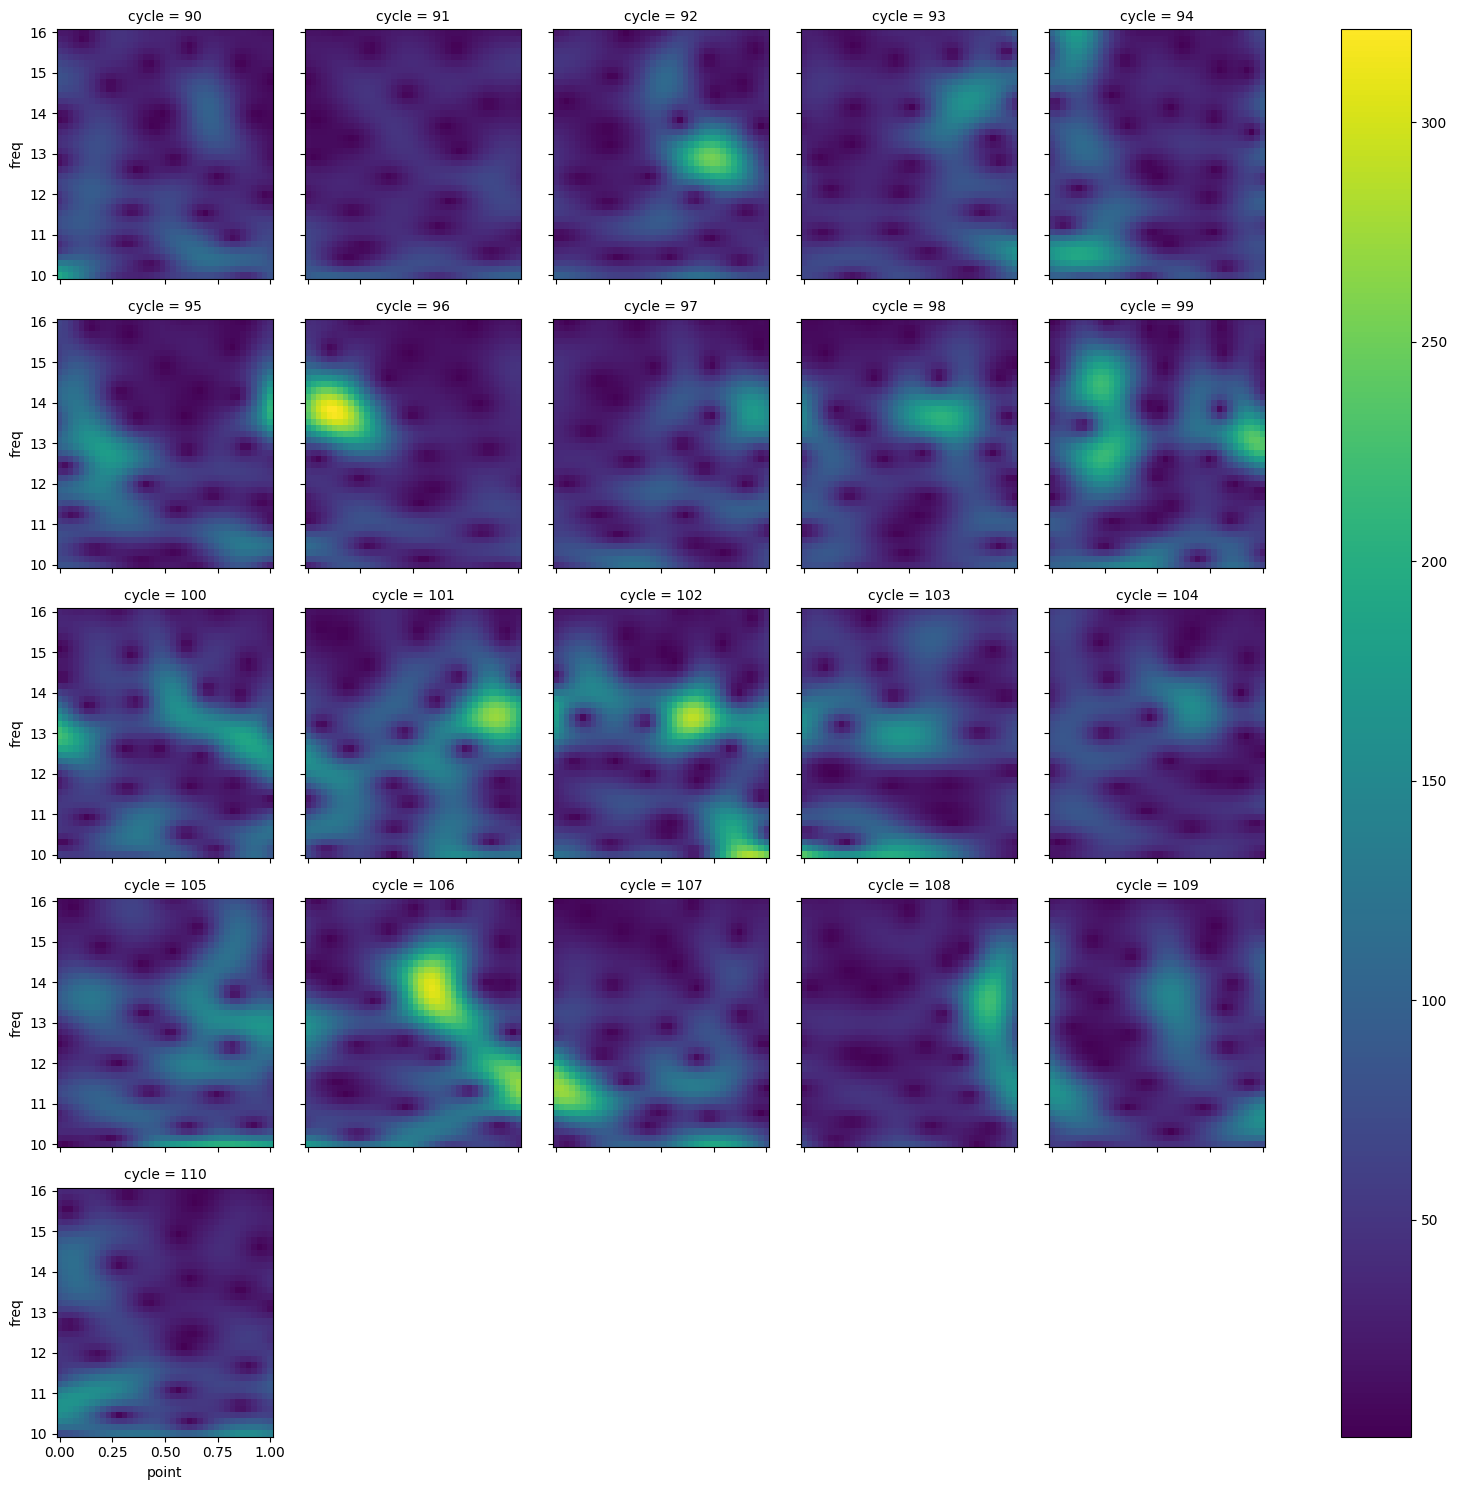

In [186]:
sigma_coupling.loc['Cz',90:110,:].plot.pcolormesh(x='point',y='freq', col = 'cycle', col_wrap = 5)

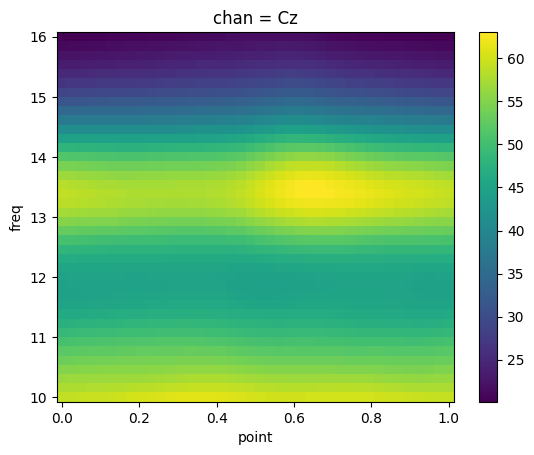

In [187]:
sigma_coupling.mean('cycle', skipna = True).sel(chan = 'Cz').plot.pcolormesh(x='point',y='freq')

In [188]:
resp_features_stretched = pd.read_excel(f'../resp_features/{subject}_resp_features_tagged_stretch.xlsx', index_col = 0)

In [189]:
resp_features_stretched

,start,transition,stop,start_time,transition_time,stop_time,cycle_duration,inspi_duration,expi_duration,cycle_freq,cycle_ratio,inspi_amplitude,expi_amplitude,inspi_volume,expi_volume,sleep_stage,Spindle_Tag,SlowWave_Tag
0,322778.0,323082.0,323679.0,1260.851562,1262.039062,1264.371094,3.519531,1.187500,2.332031,0.284129,0.337403,1.469275,1.596804,304.917354,329.273812,N2,0.0,0.0
1,323679.0,324011.0,324498.0,1264.371094,1265.667969,1267.570312,3.199219,1.296875,1.902344,0.312576,0.405372,1.163802,1.406923,273.484999,298.426835,N2,0.0,0.0
2,324498.0,324788.0,325309.0,1267.570312,1268.703125,1270.738281,3.167969,1.132812,2.035156,0.315660,0.357583,1.318122,1.481940,262.832049,311.896208,N2,0.0,0.0
3,325309.0,325632.0,326253.0,1270.738281,1272.000000,1274.425781,3.687500,1.261719,2.425781,0.271186,0.342161,1.646929,1.841724,323.905187,372.786911,N2,0.0,0.0
4,326253.0,326568.0,327042.0,1274.425781,1275.656250,1277.507812,3.082031,1.230469,1.851562,0.324461,0.399240,1.197719,1.631539,263.493212,304.672386,N2,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5517,7190474.0,7190781.0,7191531.0,28087.789062,28088.988281,28091.917969,4.128906,1.199219,2.929688,0.242195,0.290445,2.292288,2.378288,439.745738,494.556581,N2,0.0,0.0
5518,7191531.0,7191841.0,7192470.0,28091.917969,28093.128906,28095.585938,3.667969,1.210938,2.457031,0.272630,0.330138,1.609319,2.118577,304.950276,396.072727,N2,1.0,0.0
5519,7192470.0,7192765.0,7193359.0,28095.585938,28096.738281,28099.058594,3.472656,1.152344,2.320312,0.287964,0.331834,2.339790,2.317404,406.708396,451.620020,N2,0.0,0.0
5520,7193359.0,7193672.0,7194217.0,28099.058594,28100.281250,28102.410156,3.351562,1.222656,2.128906,0.298368,0.364802,1.960433,2.115444,395.124046,423.626282,N2,1.0,0.0


In [190]:
c_spindled = resp_features_stretched[resp_features_stretched['Spindle_Tag'] == 1].index.to_numpy()
c_unspindled = resp_features_stretched[resp_features_stretched['Spindle_Tag'] == 0].index.to_numpy()
c_N2 = resp_features_stretched[resp_features_stretched['sleep_stage'] == 'N2'].index.to_numpy()
c_N3 = resp_features_stretched[resp_features_stretched['sleep_stage'] == 'N3'].index.to_numpy()

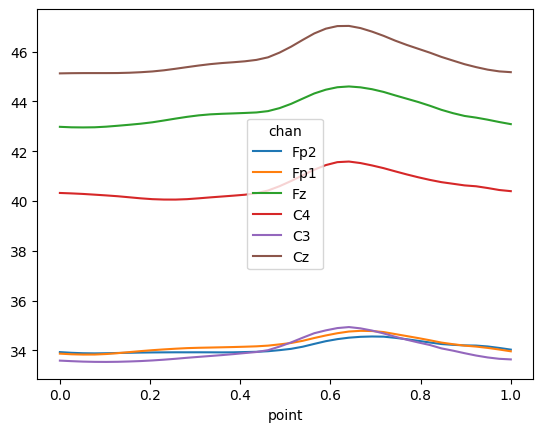

In [191]:
sigma_coupling.mean(['cycle','freq']).plot.line(x='point', hue = 'chan')

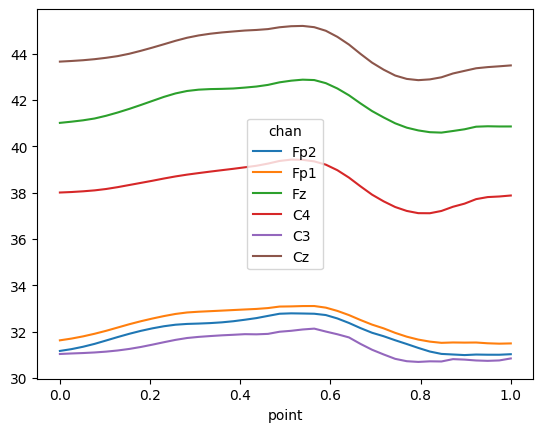

In [192]:
sigma_coupling.sel(cycle = c_N3).mean(['cycle','freq']).plot.line(x='point', hue = 'chan')

In [247]:
rows=[]
for c_label, c_type in zip(['N2','N3','spindled','unspindled'],[c_N2, c_N3, c_spindled, c_unspindled]):
    for channel in sigma_coupling.coords['chan'].values:
        sig = sigma_coupling.sel(cycle = c_type, chan=channel).mean(['cycle','freq'])
        # mi = (sig.max() - sig.min()) / (sig.max() + sig.min())
        mi = (sig.max() - sig.min()) / sig.mean()
        rows.append([channel, c_label,  float(mi)])

In [248]:
df = pd.DataFrame(rows, columns = ['chan','c_type','mi'])

In [249]:
df

,chan,c_type,mi
0,Fp2,N2,0.036367
1,Fp1,N2,0.036161
2,Fz,N2,0.048360
3,C4,N2,0.057318
4,C3,N2,0.053252
5,Cz,N2,0.057551
6,Fp2,N3,0.056442
7,Fp1,N3,0.050261
8,Fz,N3,0.054764
9,C4,N3,0.060369


<AxesSubplot: xlabel='chan', ylabel='mi'>

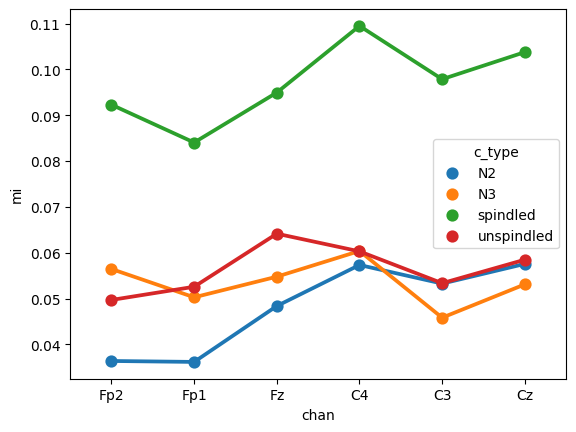

In [250]:
sns.pointplot(data=df, x = 'chan', y = 'mi', hue = 'c_type')

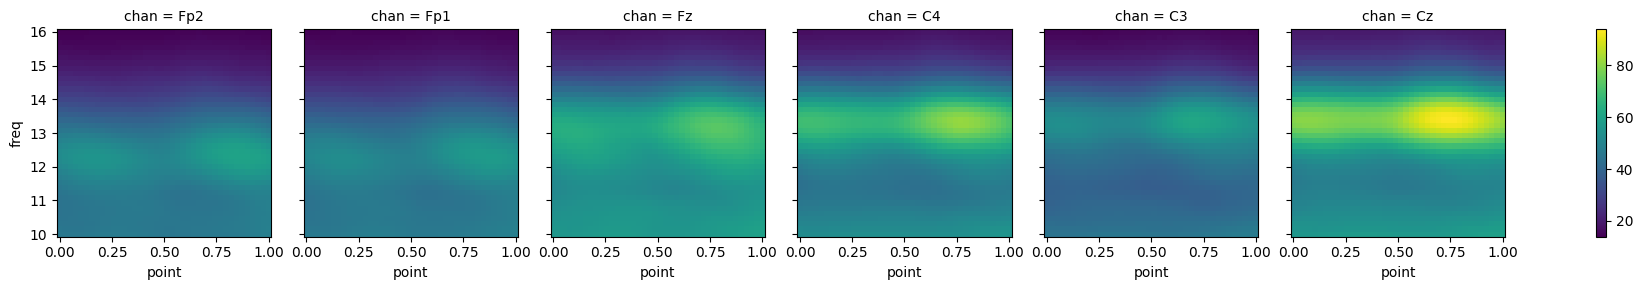

In [251]:
sigma_coupling.dropna('cycle').sel(cycle = c_spindled, freq = slice(10,16)).mean('cycle').plot.pcolormesh(x='point', y ='freq', col = 'chan')

In [252]:
sigma_coupling.coords['freq']

<xarray.DataArray 'freq' (freq: 40)>
array([10.      , 10.153846, 10.307692, 10.461538, 10.615385, 10.769231,
       10.923077, 11.076923, 11.230769, 11.384615, 11.538462, 11.692308,
       11.846154, 12.      , 12.153846, 12.307692, 12.461538, 12.615385,
       12.769231, 12.923077, 13.076923, 13.230769, 13.384615, 13.538462,
       13.692308, 13.846154, 14.      , 14.153846, 14.307692, 14.461538,
       14.615385, 14.769231, 14.923077, 15.076923, 15.230769, 15.384615,
       15.538462, 15.692308, 15.846154, 16.      ])
Coordinates:
  * freq     (freq) float64 10.0 10.15 10.31 10.46 ... 15.54 15.69 15.85 16.0

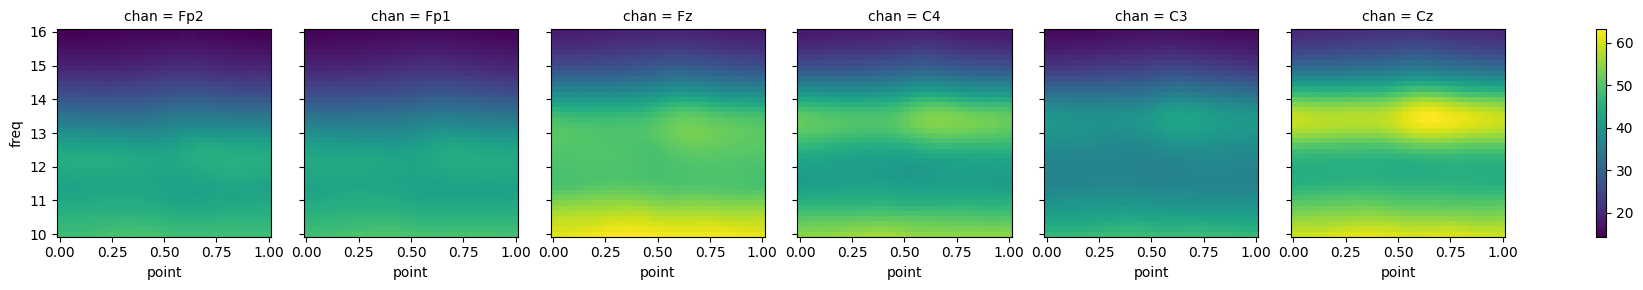

In [253]:
sigma_coupling.dropna('cycle').mean('cycle').plot.pcolormesh(x='point', y ='freq', col = 'chan')

In [235]:
sigma_coupling.sel(chan = 'Cz', freq = slice(12,16)).mean(['cycle','point']).idxmax()

<xarray.DataArray 'freq' ()>
array(13.38461538)
Coordinates:
    chan     <U2 'Cz'

In [236]:
sigma_coupling.coords['freq']

<xarray.DataArray 'freq' (freq: 40)>
array([10.      , 10.153846, 10.307692, 10.461538, 10.615385, 10.769231,
       10.923077, 11.076923, 11.230769, 11.384615, 11.538462, 11.692308,
       11.846154, 12.      , 12.153846, 12.307692, 12.461538, 12.615385,
       12.769231, 12.923077, 13.076923, 13.230769, 13.384615, 13.538462,
       13.692308, 13.846154, 14.      , 14.153846, 14.307692, 14.461538,
       14.615385, 14.769231, 14.923077, 15.076923, 15.230769, 15.384615,
       15.538462, 15.692308, 15.846154, 16.      ])
Coordinates:
  * freq     (freq) float64 10.0 10.15 10.31 10.46 ... 15.54 15.69 15.85 16.0

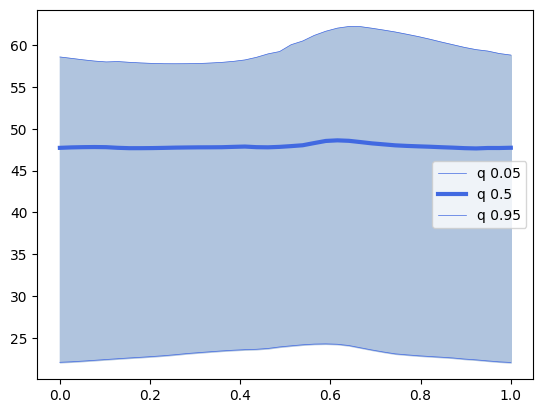

In [222]:
fig, ax = plt.subplots()
x = sigma_coupling.coords['point'].values

sigs = []
for i, q in enumerate([0.05,0.5,0.95]):
    if q == 0.5:
        lw = 3
    else:
        lw = 0.5
    sigplot = sigma_coupling.dropna('cycle').sel(chan = 'Cz').mean('cycle').quantile(q, 'freq').values
    sigs.append(sigplot)
    ax.plot(x, sigplot, lw=lw, color = 'royalblue', label = f'q {q}')
# ax.set_ylim(0,100)
ax.legend()
ax.fill_between(x, sigs[0], sigs[2], color = 'lightsteelblue')

In [226]:
resp.dropna().sort_values(by ='cycle_duration')

,start,transition,stop,start_time,transition_time,stop_time,cycle_duration,inspi_duration,expi_duration,cycle_freq,cycle_ratio,inspi_amplitude,expi_amplitude,inspi_volume,expi_volume,sleep_stage,Spindle_Tag,SlowWave_Tag
634,1380147.0,1380159.0,1380429.0,5391.199219,5391.246094,5392.300781,1.101562,0.046875,1.054688,0.907801,0.042553,0.024268,3.469073,0.190989,503.187679,N2,0.0,0.0
1238,1860666.0,1860674.0,1860961.0,7268.226562,7268.257812,7269.378906,1.152344,0.031250,1.121094,0.867797,0.027119,0.006909,3.432561,0.032991,416.136443,N2,0.0,0.0
765,1473655.0,1473843.0,1473981.0,5756.464844,5757.199219,5757.738281,1.273438,0.734375,0.539062,0.785276,0.576687,8.629558,0.925584,850.492729,44.408690,N2,0.0,0.0
766,1473981.0,1474000.0,1474320.0,5757.738281,5757.812500,5759.062500,1.324219,0.074219,1.250000,0.755162,0.056047,0.053725,4.464213,0.650687,658.924215,N2,0.0,0.0
399,1209849.0,1209859.0,1210200.0,4725.972656,4726.011719,4727.343750,1.371094,0.039062,1.332031,0.729345,0.028490,0.010437,3.156266,0.062284,451.149204,N2,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1460,2211572.0,2211758.0,2212747.0,8638.953125,8639.679688,8643.542969,4.589844,0.726562,3.863281,0.217872,0.158298,1.606198,1.350031,173.592331,289.959354,N2,0.0,0.0
345,1156133.0,1156685.0,1157333.0,4516.144531,4518.300781,4520.832031,4.687500,2.156250,2.531250,0.213333,0.460000,12.748181,11.190296,3139.679314,2265.476177,N3,0.0,1.0
4029,5260878.0,5261134.0,5262150.0,20550.304688,20551.304688,20555.273438,4.968750,1.000000,3.968750,0.201258,0.201258,3.536048,0.384737,449.033583,193.481649,N2,0.0,0.0
4538,6425169.0,6425470.0,6426454.0,25098.316406,25099.492188,25103.335938,5.019531,1.175781,3.843750,0.199222,0.234241,0.691794,0.982556,135.497274,228.941716,N2,0.0,0.0


In [239]:
fmax = sigma_coupling.sel(chan = 'Cz', freq = slice(12,16)).mean(['cycle','point']).idxmax().values

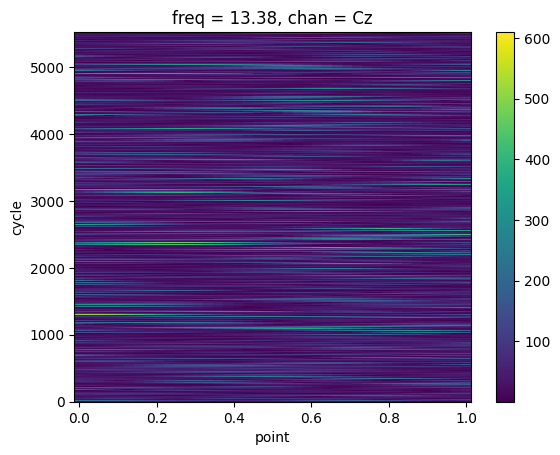

In [243]:
sigma_coupling.dropna('cycle').sel(freq = fmax, chan = 'Cz').plot.pcolormesh(x = 'point', y = 'cycle')

In [2]:
import numpy as np

In [3]:
test = np.array([[1,2,3],[4,5,6]])

In [4]:
test

array([[1, 2, 3],
       [4, 5, 6]])

In [7]:
r,c = np.where(test == 6)

In [9]:
c

array([2])

In [10]:
c[0]

2